In [ ]:
pip install PyTDC

In [ ]:
pip install rdkit-pypi

In [ ]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)

## Creating Model

In [ ]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)


In [ ]:

def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )

In [ ]:
number_of_neurons = 512
batch_s = 1

In [ ]:

def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size = batch_s, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)


In [ ]:

class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated


In [ ]:

class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim = number_of_neurons, batch_size = batch_s, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)


### MPNN

In [ ]:

def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size = batch_s,
    message_units = 64,
    message_steps = 4,
    num_attention_heads = 8,
    dense_units = number_of_neurons,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model

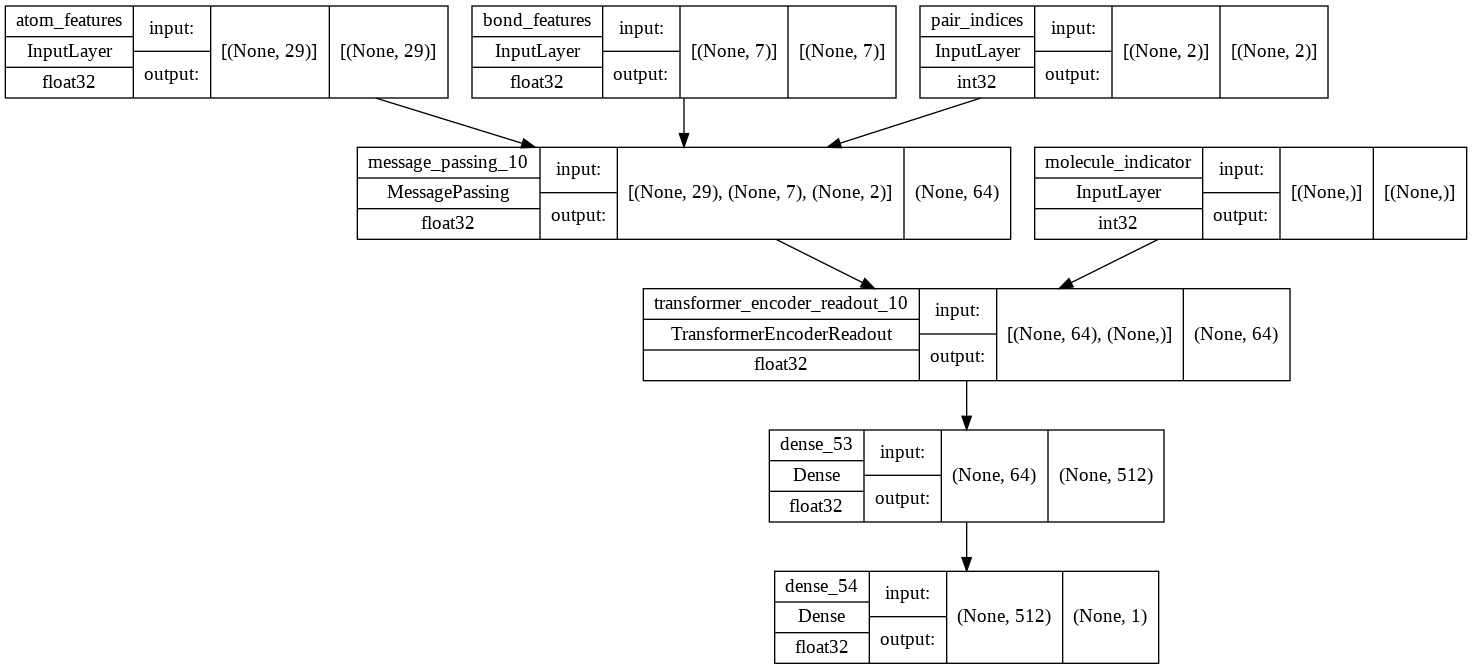

In [ ]:
mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.AUC(name="AUC")],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

### Test on a dataset

In [ ]:
from tdc.benchmark_group import admet_group
group = admet_group(path = 'data/')
benchmark = group.get('hia_hou') 

name = benchmark['name']
train_val, test = benchmark['train_val'], benchmark['test']
train, valid = group.get_train_valid_split(benchmark = name, split_type = 'default', seed = 1)

Found local copy...
generating training, validation splits...
100%|██████████| 461/461 [00:00<00:00, 2113.74it/s]


In [ ]:
x_train = graphs_from_smiles(train.Drug)
y_train = train.Y


x_valid = graphs_from_smiles(valid.Drug)
y_valid = valid.Y


x_test = graphs_from_smiles(test.Drug)
y_test = test.Y

Epoch 1/50
13/13 - 19s - loss: 0.4138 - AUC: 0.5883 - val_loss: 0.4118 - val_AUC: 0.8193 - 19s/epoch - 1s/step
Epoch 2/50
13/13 - 7s - loss: 0.3694 - AUC: 0.7208 - val_loss: 0.4082 - val_AUC: 0.8515 - 7s/epoch - 509ms/step
Epoch 3/50
13/13 - 7s - loss: 0.3642 - AUC: 0.7400 - val_loss: 0.4612 - val_AUC: 0.8683 - 7s/epoch - 548ms/step
Epoch 4/50
13/13 - 5s - loss: 0.3404 - AUC: 0.7638 - val_loss: 0.3031 - val_AUC: 0.8824 - 5s/epoch - 382ms/step
Epoch 5/50
13/13 - 4s - loss: 0.2979 - AUC: 0.8216 - val_loss: 0.3275 - val_AUC: 0.8964 - 4s/epoch - 325ms/step
Epoch 6/50
13/13 - 4s - loss: 0.2819 - AUC: 0.8552 - val_loss: 0.3740 - val_AUC: 0.9468 - 4s/epoch - 328ms/step
Epoch 7/50
13/13 - 4s - loss: 0.2744 - AUC: 0.8647 - val_loss: 0.2527 - val_AUC: 0.9412 - 4s/epoch - 321ms/step
Epoch 8/50
13/13 - 5s - loss: 0.2416 - AUC: 0.8977 - val_loss: 0.4392 - val_AUC: 0.9664 - 5s/epoch - 362ms/step
Epoch 9/50
13/13 - 4s - loss: 0.2452 - AUC: 0.8954 - val_loss: 0.2734 - val_AUC: 0.9594 - 4s/epoch - 338m

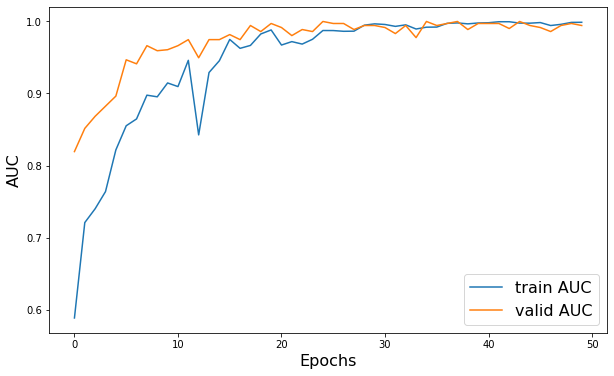

In [ ]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    validation_data = valid_dataset,
    epochs = 50,
    verbose = 2,
    class_weight = {0: 2.0, 1: 0.5},
)

plt.figure(figsize=(10, 6))
plt.plot(history.history["AUC"], label="train AUC")
plt.plot(history.history["val_AUC"], label="valid AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)

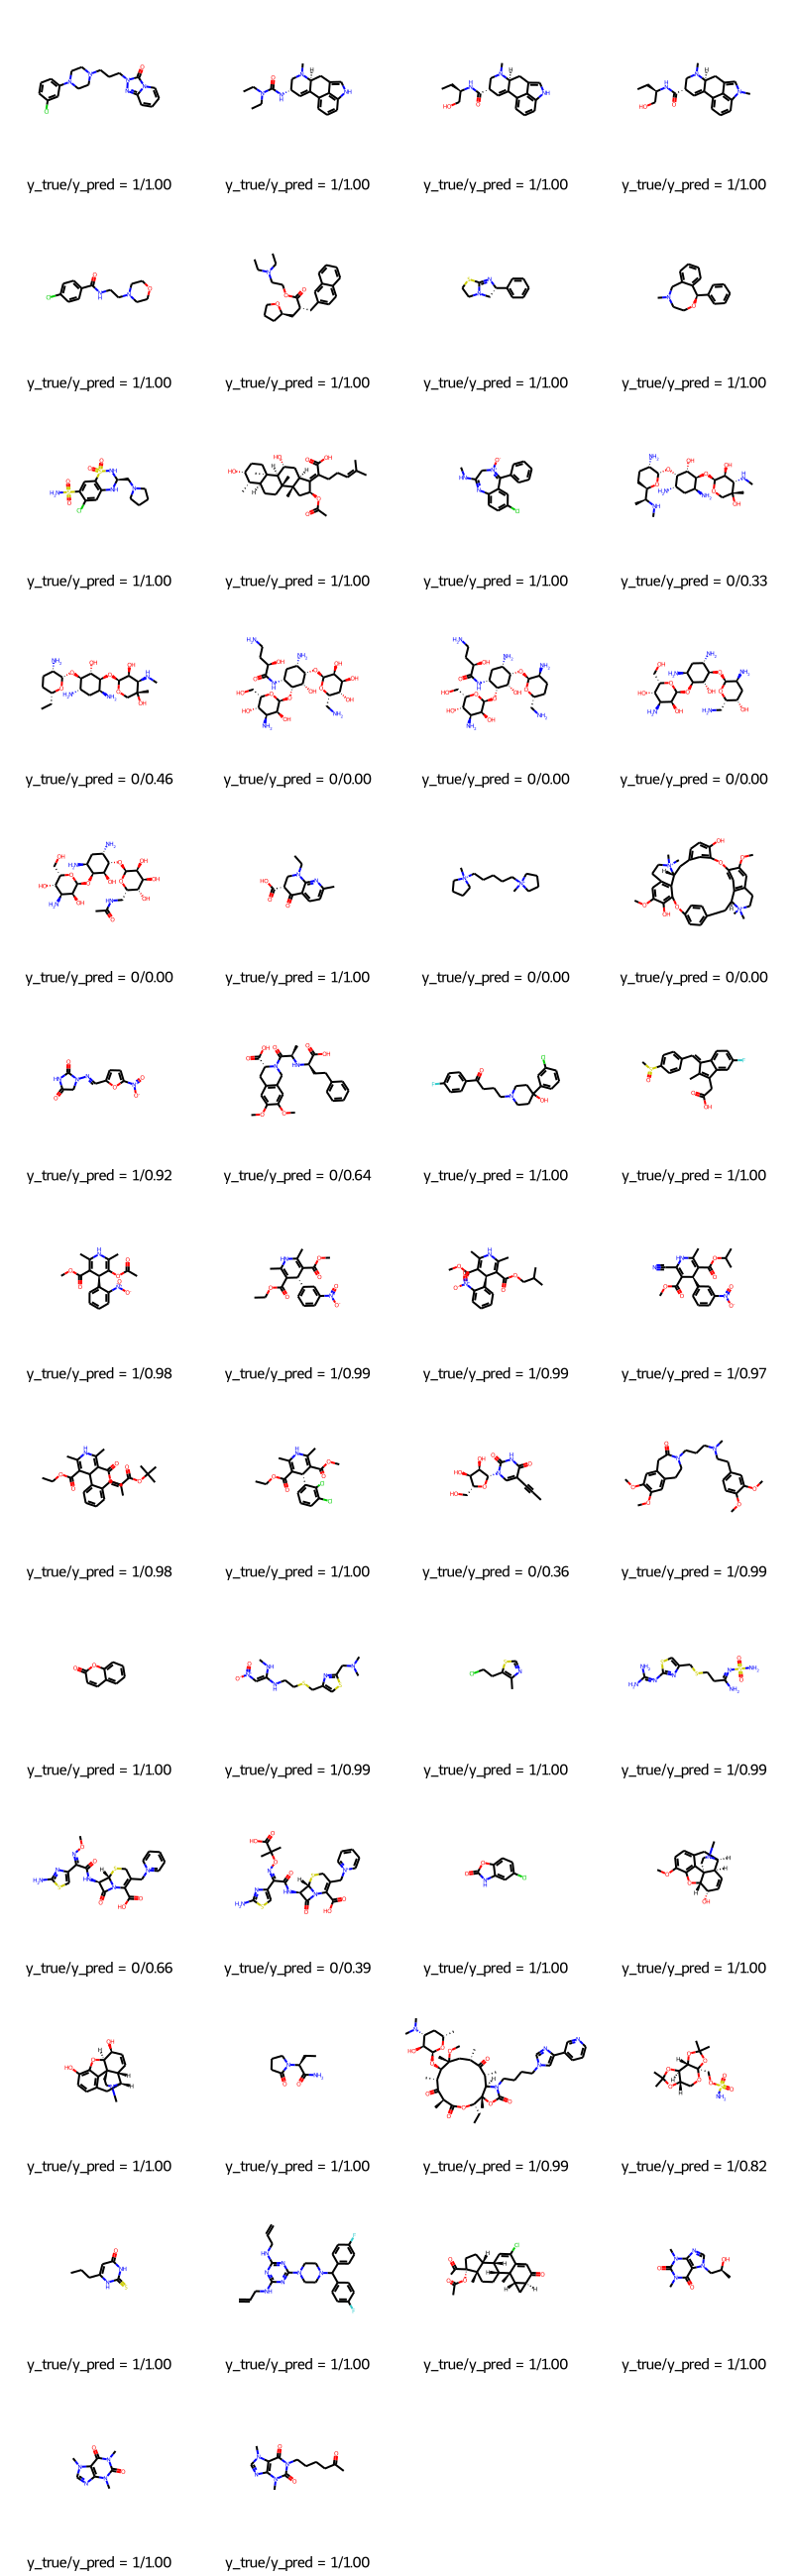

In [ ]:
molecules = [molecule_from_smiles(i) for i in test.Drug]
y_true = test.Y
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [ ]:
predictions = []

for i in y_pred:
  if i <0.5:
    predictions.append(0)
  else:
    predictions.append(1)

Accuracy :  0.9230769230769231


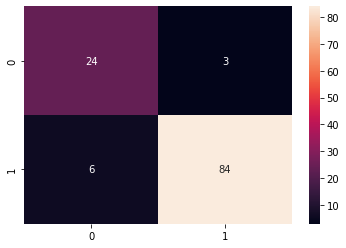

In [ ]:
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as cm
import seaborn as sns

print('Accuracy : ', acc(y_test, predictions))
sns.heatmap(cm(y_test, predictions), annot=True);

# TDC STYLE

In [ ]:
classification_datasets = ['hia_hou', 
                       'pgp_broccatelli', 
                       #'bioavailability_ma', 
                       #'bbb_martins', 
                       #'cyp2d6_veith', 
                       #'cyp3a4_veith', 
                       #'cyp2c9_veith',
                       #'cyp2d6_substrate_carbonmangels', 
                       #'cyp3a4_substrate_carbonmangels',
                       #'cyp2c9_substrate_carbonmangels',
                       #'herg',
                       #'ames',
                       #'dili'
                       ]

In [ ]:
from tdc.benchmark_group import admet_group
group = admet_group(path = 'data/')
predictions_list = []

for seed in [1, 2, 3, 4, 5]:
  predictions = {}

  for clf_dataset in classification_datasets:
    benchmark = group.get(clf_dataset)
    name = benchmark['name']
    train_val, test = benchmark['train_val'], benchmark['test']

    # split the train_val set into train & validation set
    train, valid = group.get_train_valid_split(benchmark = name, split_type = 'scaffold', seed = seed)

    x_train = graphs_from_smiles(train.Drug)
    y_train = train.Y

    x_valid = graphs_from_smiles(valid.Drug)
    y_valid = valid.Y

    x_test = graphs_from_smiles(test.Drug)
    y_test = test.Y

    # train model on training and validation set
    # and
    # test on test set 
    train_dataset = MPNNDataset(x_train, y_train)
    valid_dataset = MPNNDataset(x_valid, y_valid)
    test_dataset = MPNNDataset(x_test, y_test)

    mpnn.fit(
        train_dataset,
        validation_data = valid_dataset,
        epochs = 20,
        class_weight = {0: 2.0, 1: 0.5},
    )

    y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

    y_predictions = []
    for i in y_pred:
      if i <0.5:
        y_predictions.append(0)
      else:
        y_predictions.append(1)

    predictions[name] = y_predictions

  predictions_list.append(predictions)

results = group.evaluate_many(predictions_list)

Found local copy...
generating training, validation splits...
100%|██████████| 461/461 [00:00<00:00, 1424.39it/s]


Epoch 1/20
403/403 [==============================] - 20s 32ms/step - loss: 0.4855 - AUC: 0.5678 - val_loss: 0.4064 - val_AUC: 0.7605
Epoch 2/20
403/403 [==============================] - 7s 18ms/step - loss: 0.4372 - AUC: 0.6143 - val_loss: 0.3980 - val_AUC: 0.8081
Epoch 3/20
403/403 [==============================] - 8s 19ms/step - loss: 0.4134 - AUC: 0.6237 - val_loss: 0.4118 - val_AUC: 0.7241
Epoch 4/20
403/403 [==============================] - 8s 20ms/step - loss: 0.4181 - AUC: 0.6239 - val_loss: 0.4480 - val_AUC: 0.5014
Epoch 5/20
403/403 [==============================] - 9s 22ms/step - loss: 0.4543 - AUC: 0.4874 - val_loss: 0.3855 - val_AUC: 0.8361
Epoch 6/20
403/403 [==============================] - 8s 19ms/step - loss: 0.4490 - AUC: 0.5106 - val_loss: 0.4831 - val_AUC: 0.7185
Epoch 7/20
403/403 [==============================] - 8s 20ms/step - loss: 0.4426 - AUC: 0.5198 - val_loss: 0.4826 - val_AUC: 0.7535
Epoch 8/20
403/403 [==============================] - 8s 20ms/step -

generating training, validation splits...
100%|██████████| 973/973 [00:00<00:00, 2241.30it/s]


Epoch 1/20
851/851 [==============================] - 18s 21ms/step - loss: 0.6349 - AUC: 0.6527 - val_loss: 0.7328 - val_AUC: 0.7136
Epoch 2/20
851/851 [==============================] - 18s 21ms/step - loss: 0.6136 - AUC: 0.6582 - val_loss: 0.9552 - val_AUC: 0.7628
Epoch 3/20
851/851 [==============================] - 18s 21ms/step - loss: 0.5975 - AUC: 0.6822 - val_loss: 0.7414 - val_AUC: 0.7359
Epoch 4/20
851/851 [==============================] - 19s 22ms/step - loss: 0.5919 - AUC: 0.6823 - val_loss: 0.7724 - val_AUC: 0.6972
Epoch 5/20
851/851 [==============================] - 18s 21ms/step - loss: 0.5960 - AUC: 0.6828 - val_loss: 0.9058 - val_AUC: 0.6410
Epoch 6/20
851/851 [==============================] - 18s 21ms/step - loss: 0.6035 - AUC: 0.6618 - val_loss: 0.9351 - val_AUC: 0.6683
Epoch 7/20
851/851 [==============================] - 18s 21ms/step - loss: 0.6219 - AUC: 0.6214 - val_loss: 0.9060 - val_AUC: 0.6860
Epoch 8/20
851/851 [==============================] - 18s 21ms

generating training, validation splits...
100%|██████████| 461/461 [00:00<00:00, 2863.00it/s]


Epoch 1/20
403/403 [==============================] - 8s 19ms/step - loss: 0.4379 - AUC: 0.6609 - val_loss: 0.2570 - val_AUC: 0.8491
Epoch 2/20
403/403 [==============================] - 8s 20ms/step - loss: 0.4074 - AUC: 0.6964 - val_loss: 0.2645 - val_AUC: 0.8396
Epoch 3/20
403/403 [==============================] - 8s 20ms/step - loss: 0.3890 - AUC: 0.7249 - val_loss: 0.2732 - val_AUC: 0.7868
Epoch 4/20
403/403 [==============================] - 8s 19ms/step - loss: 0.3949 - AUC: 0.6992 - val_loss: 0.3188 - val_AUC: 0.7717
Epoch 5/20
403/403 [==============================] - 8s 21ms/step - loss: 0.3759 - AUC: 0.7298 - val_loss: 0.3263 - val_AUC: 0.6566
Epoch 6/20
403/403 [==============================] - 8s 19ms/step - loss: 0.3833 - AUC: 0.7138 - val_loss: 0.3208 - val_AUC: 0.6642
Epoch 7/20
403/403 [==============================] - 8s 21ms/step - loss: 0.3778 - AUC: 0.7229 - val_loss: 0.3279 - val_AUC: 0.6811
Epoch 8/20
403/403 [==============================] - 8s 21ms/step - 

generating training, validation splits...
100%|██████████| 973/973 [00:00<00:00, 2102.00it/s]


Epoch 1/20
851/851 [==============================] - 18s 21ms/step - loss: 0.5757 - AUC: 0.7413 - val_loss: 0.7796 - val_AUC: 0.8467
Epoch 2/20
851/851 [==============================] - 18s 21ms/step - loss: 0.5318 - AUC: 0.7754 - val_loss: 0.8594 - val_AUC: 0.7705
Epoch 3/20
851/851 [==============================] - 18s 21ms/step - loss: 0.4925 - AUC: 0.7959 - val_loss: 0.8480 - val_AUC: 0.7920
Epoch 4/20
851/851 [==============================] - 18s 22ms/step - loss: 0.4842 - AUC: 0.8060 - val_loss: 0.8186 - val_AUC: 0.7910
Epoch 5/20
851/851 [==============================] - 19s 23ms/step - loss: 0.4904 - AUC: 0.7981 - val_loss: 0.9218 - val_AUC: 0.8493
Epoch 6/20
851/851 [==============================] - 18s 22ms/step - loss: 0.5163 - AUC: 0.7805 - val_loss: 0.9278 - val_AUC: 0.8041
Epoch 7/20
851/851 [==============================] - 19s 22ms/step - loss: 0.4678 - AUC: 0.8187 - val_loss: 0.6981 - val_AUC: 0.8923
Epoch 8/20
851/851 [==============================] - 18s 21ms

generating training, validation splits...
100%|██████████| 461/461 [00:00<00:00, 2593.58it/s]


Epoch 1/20
403/403 [==============================] - 9s 21ms/step - loss: 0.4741 - AUC: 0.6242 - val_loss: 0.5508 - val_AUC: 0.7035
Epoch 2/20
403/403 [==============================] - 8s 20ms/step - loss: 0.3931 - AUC: 0.6665 - val_loss: 0.4894 - val_AUC: 0.6843
Epoch 3/20
403/403 [==============================] - 8s 19ms/step - loss: 0.3813 - AUC: 0.6891 - val_loss: 0.5136 - val_AUC: 0.6314
Epoch 4/20
403/403 [==============================] - 8s 19ms/step - loss: 0.3812 - AUC: 0.7038 - val_loss: 0.5056 - val_AUC: 0.6442
Epoch 5/20
403/403 [==============================] - 8s 19ms/step - loss: 0.3755 - AUC: 0.7164 - val_loss: 0.5231 - val_AUC: 0.6587
Epoch 6/20
403/403 [==============================] - 8s 20ms/step - loss: 0.3758 - AUC: 0.7404 - val_loss: 0.4396 - val_AUC: 0.7532
Epoch 7/20
403/403 [==============================] - 8s 19ms/step - loss: 0.3619 - AUC: 0.7430 - val_loss: 0.4684 - val_AUC: 0.7292
Epoch 8/20
403/403 [==============================] - 8s 20ms/step - 

generating training, validation splits...
100%|██████████| 973/973 [00:00<00:00, 2147.77it/s]


Epoch 1/20
851/851 [==============================] - 18s 22ms/step - loss: 0.5744 - AUC: 0.7412 - val_loss: 0.9296 - val_AUC: 0.7469
Epoch 2/20
851/851 [==============================] - 18s 22ms/step - loss: 0.5203 - AUC: 0.7950 - val_loss: 1.1666 - val_AUC: 0.7544
Epoch 3/20
851/851 [==============================] - 19s 22ms/step - loss: 0.5012 - AUC: 0.8093 - val_loss: 1.1460 - val_AUC: 0.8269
Epoch 4/20
851/851 [==============================] - 18s 21ms/step - loss: 0.4815 - AUC: 0.8206 - val_loss: 1.2532 - val_AUC: 0.7989
Epoch 5/20
851/851 [==============================] - 18s 21ms/step - loss: 0.4999 - AUC: 0.8010 - val_loss: 0.8891 - val_AUC: 0.8526
Epoch 6/20
851/851 [==============================] - 19s 22ms/step - loss: 0.4860 - AUC: 0.8222 - val_loss: 1.0370 - val_AUC: 0.7318
Epoch 7/20
851/851 [==============================] - 18s 22ms/step - loss: 0.4869 - AUC: 0.8219 - val_loss: 0.8809 - val_AUC: 0.7882
Epoch 8/20
851/851 [==============================] - 18s 21ms

generating training, validation splits...
100%|██████████| 461/461 [00:00<00:00, 2760.77it/s]


Epoch 1/20
403/403 [==============================] - 8s 20ms/step - loss: 0.4181 - AUC: 0.7201 - val_loss: 0.4715 - val_AUC: 0.7222
Epoch 2/20
403/403 [==============================] - 8s 20ms/step - loss: 0.3751 - AUC: 0.7365 - val_loss: 0.4600 - val_AUC: 0.6343
Epoch 3/20
403/403 [==============================] - 8s 20ms/step - loss: 0.3575 - AUC: 0.7698 - val_loss: 0.4238 - val_AUC: 0.6620
Epoch 4/20
403/403 [==============================] - 8s 19ms/step - loss: 0.3528 - AUC: 0.7736 - val_loss: 0.4620 - val_AUC: 0.6227
Epoch 5/20
403/403 [==============================] - 8s 19ms/step - loss: 0.3397 - AUC: 0.7939 - val_loss: 0.4347 - val_AUC: 0.6852
Epoch 6/20
403/403 [==============================] - 8s 20ms/step - loss: 0.3240 - AUC: 0.8106 - val_loss: 0.4601 - val_AUC: 0.6505
Epoch 7/20
403/403 [==============================] - 8s 20ms/step - loss: 0.3519 - AUC: 0.7823 - val_loss: 0.4862 - val_AUC: 0.6690
Epoch 8/20
403/403 [==============================] - 8s 20ms/step - 

generating training, validation splits...
100%|██████████| 973/973 [00:00<00:00, 2165.71it/s]


Epoch 1/20
851/851 [==============================] - 18s 21ms/step - loss: 0.5394 - AUC: 0.7731 - val_loss: 0.6231 - val_AUC: 0.9132
Epoch 2/20
851/851 [==============================] - 19s 22ms/step - loss: 0.4989 - AUC: 0.8110 - val_loss: 0.5104 - val_AUC: 0.9031
Epoch 3/20
851/851 [==============================] - 18s 21ms/step - loss: 0.4812 - AUC: 0.8289 - val_loss: 0.5187 - val_AUC: 0.9199
Epoch 4/20
851/851 [==============================] - 19s 22ms/step - loss: 0.4724 - AUC: 0.8350 - val_loss: 0.4486 - val_AUC: 0.9523
Epoch 5/20
851/851 [==============================] - 19s 23ms/step - loss: 0.4507 - AUC: 0.8472 - val_loss: 0.4861 - val_AUC: 0.9482
Epoch 6/20
851/851 [==============================] - 18s 21ms/step - loss: 0.4480 - AUC: 0.8436 - val_loss: 0.5697 - val_AUC: 0.9211
Epoch 7/20
851/851 [==============================] - 19s 22ms/step - loss: 0.4481 - AUC: 0.8496 - val_loss: 0.5133 - val_AUC: 0.9243
Epoch 8/20
851/851 [==============================] - 18s 21ms

generating training, validation splits...
100%|██████████| 461/461 [00:00<00:00, 2631.18it/s]


Epoch 1/20
397/397 [==============================] - 9s 23ms/step - loss: 0.4096 - AUC: 0.6939 - val_loss: 0.6935 - val_AUC: 0.4825
Epoch 2/20
397/397 [==============================] - 9s 22ms/step - loss: 0.3742 - AUC: 0.7159 - val_loss: 0.5302 - val_AUC: 0.5576
Epoch 3/20
397/397 [==============================] - 8s 21ms/step - loss: 0.3429 - AUC: 0.7703 - val_loss: 0.6016 - val_AUC: 0.5238
Epoch 4/20
397/397 [==============================] - 9s 22ms/step - loss: 0.3282 - AUC: 0.8005 - val_loss: 0.5202 - val_AUC: 0.5539
Epoch 5/20
397/397 [==============================] - 9s 22ms/step - loss: 0.3104 - AUC: 0.8228 - val_loss: 0.5052 - val_AUC: 0.4937
Epoch 6/20
397/397 [==============================] - 9s 22ms/step - loss: 0.3087 - AUC: 0.8372 - val_loss: 0.6849 - val_AUC: 0.4687
Epoch 7/20
397/397 [==============================] - 9s 24ms/step - loss: 0.2712 - AUC: 0.8780 - val_loss: 0.6983 - val_AUC: 0.6190
Epoch 8/20
397/397 [==============================] - 9s 22ms/step - 

generating training, validation splits...
100%|██████████| 973/973 [00:00<00:00, 2148.99it/s]


Epoch 1/20
851/851 [==============================] - 25s 29ms/step - loss: 0.5656 - AUC: 0.7683 - val_loss: 0.5266 - val_AUC: 0.8753
Epoch 2/20
851/851 [==============================] - 26s 30ms/step - loss: 0.4616 - AUC: 0.8366 - val_loss: 0.5781 - val_AUC: 0.9377
Epoch 3/20
851/851 [==============================] - 23s 28ms/step - loss: 0.4741 - AUC: 0.8279 - val_loss: 0.4959 - val_AUC: 0.9024
Epoch 4/20
851/851 [==============================] - 24s 28ms/step - loss: 0.4526 - AUC: 0.8488 - val_loss: 0.4874 - val_AUC: 0.9190
Epoch 5/20
851/851 [==============================] - 25s 30ms/step - loss: 0.4324 - AUC: 0.8533 - val_loss: 0.4714 - val_AUC: 0.8833
Epoch 6/20
851/851 [==============================] - 26s 31ms/step - loss: 0.4288 - AUC: 0.8514 - val_loss: 0.3906 - val_AUC: 0.9423
Epoch 7/20
851/851 [==============================] - 25s 30ms/step - loss: 0.4090 - AUC: 0.8596 - val_loss: 0.5316 - val_AUC: 0.9255
Epoch 8/20
851/851 [==============================] - 25s 30ms

In [ ]:
results

{'hia_hou': [0.689, 0.115], 'pgp_broccatelli': [0.712, 0.04]}

In [ ]:
results

{'dili': [0.774, 0.071]}

In [ ]:
results # 200 neurons on 2nd last layer 

{'dili': [0.747, 0.061]}

In [ ]:
results # 1:1

{'dili': [0.748, 0.03]}

In [ ]:
results # batch_size = 1, epochs =20, 1:1

{'dili': [0.722, 0.009]}

In [ ]:
results # batch_size = 1, epochs =20

{'dili': [0.74, 0.047]}

In [ ]:
results # 50 epochs

{'dili': [0.759, 0.016]}

In [ ]:
results # 10 epochs

{'hia_hou': [0.751, 0.055], 'pgp_broccatelli': [0.732, 0.113]}